# Machine learning


In [32]:
from sklearn.linear_model import LogisticRegression

from sklearn import metrics

from sklearn import preprocessing

from sklearn import utils

from sklearn.grid_search import GridSearchCV, RandomizedSearchCV

from sklearn.cross_validation import train_test_split

# For data manipulation

In [33]:
import pandas as pd

import numpy as np


# To plot

In [34]:
import matplotlib.pyplot as plt

import seaborn

# sql import

In [35]:
import psycopg2
import datetime


# Load dataset Read sqlite query results into a pandas DataFrame

In [36]:
### Database connection

conn_string = "host='localhost' dbname='stockmarket' user='postgres' password='123456'"
conn = psycopg2.connect(conn_string)

## Read dataset

df = pd.read_sql_query(
    '''select i.date ,i.open ,i.high ,i.low ,i.close ,i.adj_close ,i.volume ,c.name
    from information i 
    join company c
    on i.company_id=c.id
    where company_id = {}'''.format(3)  , conn, index_col='date')
df.index = pd.to_datetime(df.index)


# Verify that result of SQL query is stored in the dataframe


In [37]:
print(df.head())

                open      high       low     close  adj_close      volume  \
date                                                                        
1986-03-12  0.444196  0.448661  0.441964  0.441964   0.020108  21420000.0   
1986-03-13  0.441964  0.446429  0.435268  0.441964   0.020108  28991200.0   
1986-03-14  0.441964  0.468750  0.441964  0.466518   0.021225  96213600.0   
1986-03-17  0.464286  0.464286  0.453125  0.464286   0.021123  29680000.0   
1986-03-18  0.464286  0.486607  0.462054  0.479911   0.021834  62339200.0   

            name  
date              
1986-03-12  AAPL  
1986-03-13  AAPL  
1986-03-14  AAPL  
1986-03-17  AAPL  
1986-03-18  AAPL  


## adding  features

In [38]:
conn.close()

df= df.dropna()

df['open-close'] = df.open - df.close

df['high-low'] = df.high - df.low

# relative strength index


In [39]:
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
    rs = pd.stats.moments.ewma(u, com=period-1, adjust=False) / \
         pd.stats.moments.ewma(d, com=period-1, adjust=False)
    return 100 - 100 / (1 + rs)


### We will use 10-days moving average, correlation,relative strength index (RSI), the difference between the open price of yesterday and today, difference close price of yesterday and open price of today,open, high, low, and close price as indicators to make the prediction.

In [40]:
df['S_10'] = df['close'].rolling(window=10).mean()

df['Corr'] = df['close'].rolling(window=10).corr(df['S_10'])

df['RSI'] = RSI(series=df['close'], period =10)

df['open-close'] = df['open'] - df['close'].shift(1)

df['open-open'] = df['open'] - df['open'].shift(1)

df = df.dropna()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(com=9,min_periods=0,adjust=False,ignore_na=False).mean()
  # This is added back by InteractiveShellApp.init_path()


## The dependent variable is same as discussed in the above example. If the tomorrow’s closing price is higher than today’s closing price, then we will buy the stock (1), else we will sell it (-1).


In [41]:
feature_cols = ['open','high','low','close','S_10','Corr','RSI','open-close','open-open']

x = df[feature_cols]

y = np.where (df['close'].shift(-1) > df['close'],1,-1)

# split our data

In [42]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, random_state=4)

## We will instantiate the logistic regression using ‘LogisticRegression’ function and fit the model on the training dataset using ‘fit’ function.

In [43]:
model = LogisticRegression()

model = model.fit (x_train,y_train)

# Examine The Coefficients

In [44]:
print(pd.DataFrame(list(zip(x.columns, np.transpose(model.coef_)))))

            0                         1
0        open   [0.0028731425457884374]
1        high     [0.08422596634593675]
2         low     [0.09984257748682968]
3       close     [-0.1498717597224444]
4        S_10   [-0.036084583907396856]
5        Corr     [0.06105623687525228]
6         RSI  [0.00016489237078286614]
7  open-close     [0.03223369018096681]
8   open-open    [-0.05260000056966648]


# Calculate Class Probabilities

In [45]:
probability = model.predict_proba(x_test)

print (probability)

[[0.51098231 0.48901769]
 [0.51191149 0.48808851]
 [0.49308376 0.50691624]
 ...
 [0.49974154 0.50025846]
 [0.50078098 0.49921902]
 [0.49037691 0.50962309]]


# Predict Class Labels

In [46]:
df['Predicted_Signal'] = model.predict(x)
print(df['Predicted_Signal'].head())

date
1986-04-08   -1
1986-04-09   -1
1986-04-10   -1
1986-04-11   -1
1986-04-14   -1
Name: Predicted_Signal, dtype: int32


# Confusion matrix

In [47]:
print (metrics.confusion_matrix(y_test, predicted))

[[609 194]
 [562 245]]


# Classification report

In [48]:
print (metrics.classification_report(y_test, predicted))

             precision    recall  f1-score   support

         -1       0.52      0.76      0.62       803
          1       0.56      0.30      0.39       807

avg / total       0.54      0.53      0.50      1610



# Model accuracy

In [49]:
print (model.score(x_test,y_test))

0.5304347826086957


## Create Trading Strategy Using The Model We will predict the signal to buy (1) or sell (-1) and calculate the cumulative returns for test dataset. Next, we will calculate the cumulative strategy return based on the signal predicted by the model in the test dataset. We will also plot the cumulative returns.


# Cumulative Returns

In [50]:
split = int(0.8*len(df))

df['Returns'] = np.log(df['close']/df['close'].shift(1))

Cumulative_Returns = df[split:]['Returns'].cumsum()*100

print('HEAD OF RETURNS','\n',df['Returns'].head(),'\n\n\n\n','TAIL OF RETURNS','\n',df['Returns'].tail(),'\n\n\n\n','TAIL OF CUMULATIVE RETURNS','\n',Cumulative_Returns.head(),'\n\n\n\n','HEAD OF CUMULATIVE RETURNS','\n',Cumulative_Returns.tail())

HEAD OF RETURNS 
 date
1986-04-08         NaN
1986-04-09   -0.018266
1986-04-10    0.004597
1986-04-11   -0.009216
1986-04-14   -0.004640
Name: Returns, dtype: float64 



 TAIL OF RETURNS 
 date
2018-03-07   -0.009326
2018-03-08    0.010853
2018-03-09    0.017035
2018-03-12    0.009621
2018-03-13   -0.009677
Name: Returns, dtype: float64 



 TAIL OF CUMULATIVE RETURNS 
 date
2011-10-18    0.534295
2011-10-19   -5.222237
2011-10-20   -6.056065
2011-10-21   -6.675214
2011-10-24   -3.444441
Name: Returns, dtype: float64 



 HEAD OF CUMULATIVE RETURNS 
 date
2018-03-07    107.063660
2018-03-08    108.148992
2018-03-09    109.852493
2018-03-12    110.814627
2018-03-13    109.846940
Name: Returns, dtype: float64


# Cumulative Startegy Returns

In [51]:
df['Strategy_Returns'] = df['Returns'] * df['Predicted_Signal'].shift(1)

Cum_Strategy_Returns = df[split:]['Strategy_Returns'].cumsum()*100

print('HEAD OF STRATEGY RETURNS','\n',df['Strategy_Returns'].head(),'\n\n\n\n','TAIL OF STRATEGY RETURNS','\n',df['Strategy_Returns'].tail(),'\n\n\n\n','TAIL OF CUMULATIVE STRATEGY RETURNS','\n',Cum_Strategy_Returns.head(),'\n\n\n\n','HEAD OF CUMULATIVE STRATEGY RETURNS','\n',Cum_Strategy_Returns.tail())

HEAD OF STRATEGY RETURNS 
 date
1986-04-08         NaN
1986-04-09    0.018266
1986-04-10   -0.004597
1986-04-11    0.009216
1986-04-14    0.004640
Name: Strategy_Returns, dtype: float64 



 TAIL OF STRATEGY RETURNS 
 date
2018-03-07   -0.009326
2018-03-08    0.010853
2018-03-09   -0.017035
2018-03-12   -0.009621
2018-03-13   -0.009677
Name: Strategy_Returns, dtype: float64 



 TAIL OF CUMULATIVE STRATEGY RETURNS 
 date
2011-10-18    0.534295
2011-10-19   -5.222237
2011-10-20   -6.056065
2011-10-21   -6.675214
2011-10-24   -3.444441
Name: Strategy_Returns, dtype: float64 



 HEAD OF CUMULATIVE STRATEGY RETURNS 
 date
2018-03-07    58.724599
2018-03-08    59.809932
2018-03-09    58.106431
2018-03-12    57.144297
2018-03-13    56.176610
Name: Strategy_Returns, dtype: float64


# Plot the results to visualize the performance

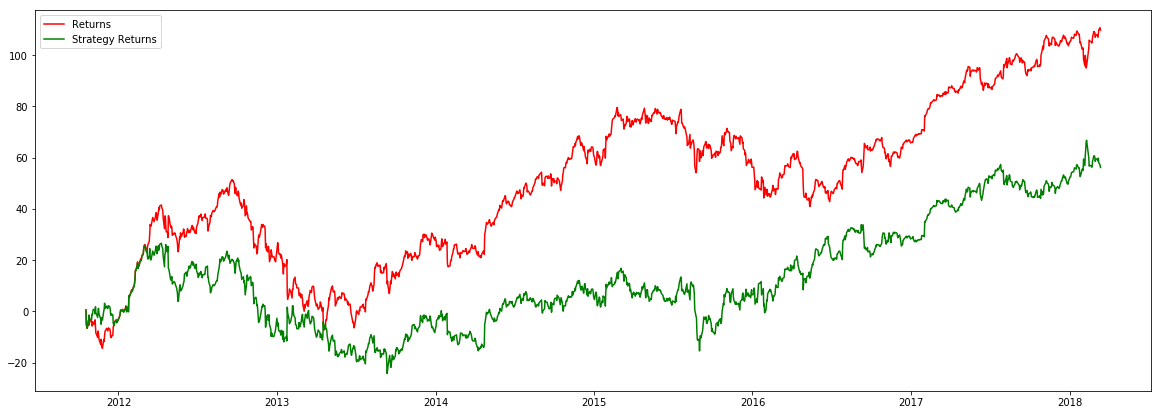

In [52]:
plt.figure(figsize=(20, 7))

plt.plot(Cumulative_Returns, color='r', label='Returns')

plt.plot(Cum_Strategy_Returns, color='g', label='Strategy Returns')

plt.legend()

plt.show()

# calculate sharpe ratio



### The Sharpe ratio is the return earned in excess of the market return per unit of volatility.First, we will calculate the standard deviation of the cumulative returns,and use it further to calculate the Sharpe ratio

In [53]:
std = Cum_Strategy_Returns.std()

sharpe = (Cum_Strategy_Returns-Cumulative_Returns)/std

sharpe = sharpe.mean()

print('sharpe ratio: %.2f' % sharpe)

print(df.head())

sharpe ratio: -1.80
                open      high       low     close  adj_close      volume  \
date                                                                        
1986-04-08  0.486607  0.495536  0.486607  0.493304   0.022443  48305600.0   
1986-04-09  0.493304  0.495536  0.479911  0.484375   0.022037  33829600.0   
1986-04-10  0.484375  0.488839  0.479911  0.486607   0.022139  27496000.0   
1986-04-11  0.486607  0.491071  0.482143  0.482143   0.021936  18916800.0   
1986-04-14  0.482143  0.486607  0.477679  0.479911   0.021834  21240800.0   

            name  open-close  high-low      S_10      Corr        RSI  \
date                                                                    
1986-04-08  AAPL         0.0  0.008929  0.492411 -0.582903  63.486852   
1986-04-09  AAPL         0.0  0.015625  0.491071 -0.704894  57.170527   
1986-04-10  AAPL         0.0  0.008928  0.489286 -0.600774  58.322214   
1986-04-11  AAPL         0.0  0.008928  0.487054 -0.028360  55.033643   
19